# Introduction
##### This Kernel is written based on a paper which utilized 'denoising autoencoder' to detect credit card fraud
##### Source : https://arxiv.org/pdf/1908.11553.pdf
##### =============================================
##### The idea is really simple. To solve the problem of imbalanced dataset of credit card fruad, this paper proposed an oversampling technique(SMOTE) and feed oversampled dataset into denoising autoencoder.
##### Then with the dataset represented by denoising autoencoder, they make classifier learn the pattern between normal transaction and abnormal transaction

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing
##### For dataset preprocessing, drop 'Time' data and normalized the 'Amount' part. 
##### Other features don't need to do normalization. Then choose the test sample, which account for 20% of total dataset


In [3]:
df = pd.read_csv('../input/creditcardfraud/creditcard.csv')

x = df[df.columns[1:30]].to_numpy()
y = df[df.columns[30]].to_numpy()

# prepare data
df = pd.concat([pd.DataFrame(x)], axis=1)

# normalize Amount
df[28] = (df[28] - df[28].mean())/df[28].std()

# Split the data
x = df.to_numpy()
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,stratify=y,test_size=0.2)

## Oversampling (SMOTE)
##### Before oversampling, there are 227451 sample normal train data and 394 sample abnormal data
##### After oversampling, there are 227451 sample normal train data and also 227451 sample abnormal data

In [4]:
sm = SMOTE()
x_train_all, y_train_all = sm.fit_resample(x_train_all,y_train_all)
np.unique(y_train_all, return_counts=True)

(array([0, 1]), array([227451, 227451]))

In [5]:
# Describe oversampled dataset

## Denoising autoencoder
##### Paper proposed a 7 layer of autoencoder for dataset denoising process
##### After oversampling, they add Gaussian noise to the training dataset, the feed the training dataset in this decnoising autoencoder

In [6]:
# Split data for training autoencoder
x_train_all, x_valid, y_train_all, y_valid = train_test_split(x_train_all,y_train_all,test_size=0.2)

In [7]:
x_valid.shape

(90981, 29)

In [8]:
# Model
keras.backend.clear_session()

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[29]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(22, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
])

denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(15, activation='relu', input_shape=[10]),
    keras.layers.Dense(22, activation='relu'),
    keras.layers.Dense(29),
])

denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(), metrics=['mse'])

2022-06-01 09:06:48.947194: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
history = denoising_ae.fit(x_train_all, x_train_all, epochs=40, validation_data=(x_valid,x_valid))

2022-06-01 09:06:49.330733: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
11373/11373 [==============================] - 37s 3ms/step - loss: 0.5692 - mse: 0.5692 - val_loss: 0.3524 - val_mse: 0.3524
Epoch 2/40
11373/11373 [==============================] - 36s 3ms/step - loss: 0.3007 - mse: 0.3007 - val_loss: 0.2539 - val_mse: 0.2539
Epoch 3/40
11373/11373 [==============================] - 34s 3ms/step - loss: 0.2551 - mse: 0.2551 - val_loss: 0.2293 - val_mse: 0.2293
Epoch 4/40
11373/11373 [==============================] - 34s 3ms/step - loss: 0.2353 - mse: 0.2353 - val_loss: 0.2032 - val_mse: 0.2032
Epoch 5/40
11373/11373 [==============================] - 34s 3ms/step - loss: 0.2218 - mse: 0.2218 - val_loss: 0.1966 - val_mse: 0.1966
Epoch 6/40
11373/11373 [==============================] - 35s 3ms/step - loss: 0.2124 - mse: 0.2124 - val_loss: 0.1831 - val_mse: 0.1831
Epoch 7/40
11373/11373 [==============================] - 34s 3ms/step - loss: 0.2030 - mse: 0.2030 - val_loss: 0.1824 - val_mse: 0.1824
Epoch 8/40
11373/11373 [=================

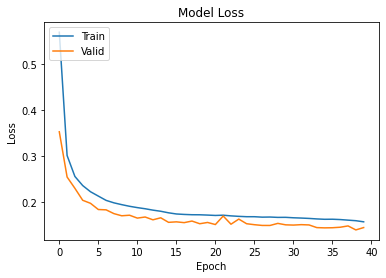

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [11]:
# making denoised dataset
denoising_x_train = denoising_ae.predict(x_train_all)
denoising_x_valid = denoising_ae.predict(x_valid)

## Classifier
##### Paper proposed a 6 layers autoencoder for dataset denoise proess. After got denoised training dataset from denoised autoencoder, the dataset go into this deep fully connected neural network classifier
##### In the end, this model used SoftMax with cross-entropy as the loss function for final classification.

In [12]:
keras.backend.clear_session()

# The classifier with out denoising autoencoder dataset
base_classifier = keras.models.Sequential([
    keras.layers.Dense(22, activation='relu',input_shape=[29]),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

base_classifier.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [13]:
clf_base_history = base_classifier.fit(x_train_all, y_train_all, epochs=10, validation_data=(x_valid,y_valid))

Epoch 1/10
11373/11373 [==============================] - 33s 3ms/step - loss: 0.0418 - accuracy: 0.9843 - val_loss: 0.0103 - val_accuracy: 0.9977
Epoch 2/10
11373/11373 [==============================] - 32s 3ms/step - loss: 0.0110 - accuracy: 0.9973 - val_loss: 0.0071 - val_accuracy: 0.9982
Epoch 3/10
11373/11373 [==============================] - 31s 3ms/step - loss: 0.0089 - accuracy: 0.9979 - val_loss: 0.0053 - val_accuracy: 0.9986
Epoch 4/10
11373/11373 [==============================] - 32s 3ms/step - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.0038 - val_accuracy: 0.9992
Epoch 5/10
11373/11373 [==============================] - 33s 3ms/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.0069 - val_accuracy: 0.9976
Epoch 6/10
11373/11373 [==============================] - 31s 3ms/step - loss: 0.0057 - accuracy: 0.9987 - val_loss: 0.0038 - val_accuracy: 0.9993
Epoch 7/10
11373/11373 [==============================] - 32s 3ms/step - loss: 0.0052 - accuracy: 0.9988 - val_loss: 0

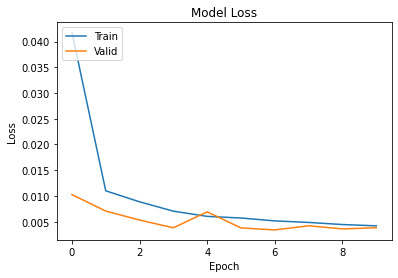

In [14]:
plt.plot(clf_base_history.history['loss'])
plt.plot(clf_base_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [15]:
keras.backend.clear_session()

classifier_1 = keras.models.Sequential([
    keras.layers.Dense(22, activation='relu',input_shape=[29]),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

classifier_1.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [16]:
clf_1_history = classifier_1.fit(denoising_x_train, y_train_all, epochs=10, validation_data=(denoising_x_valid,y_valid))

Epoch 1/10
11373/11373 [==============================] - 32s 3ms/step - loss: 0.0649 - accuracy: 0.9755 - val_loss: 0.0279 - val_accuracy: 0.9910
Epoch 2/10
11373/11373 [==============================] - 32s 3ms/step - loss: 0.0298 - accuracy: 0.9900 - val_loss: 0.0212 - val_accuracy: 0.9936
Epoch 3/10
11373/11373 [==============================] - 31s 3ms/step - loss: 0.0236 - accuracy: 0.9926 - val_loss: 0.0164 - val_accuracy: 0.9952
Epoch 4/10
11373/11373 [==============================] - 32s 3ms/step - loss: 0.0210 - accuracy: 0.9936 - val_loss: 0.0150 - val_accuracy: 0.9961
Epoch 5/10
11373/11373 [==============================] - 32s 3ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.0153 - val_accuracy: 0.9954
Epoch 6/10
11373/11373 [==============================] - 31s 3ms/step - loss: 0.0177 - accuracy: 0.9947 - val_loss: 0.0118 - val_accuracy: 0.9967
Epoch 7/10
11373/11373 [==============================] - 31s 3ms/step - loss: 0.0164 - accuracy: 0.9953 - val_loss: 0

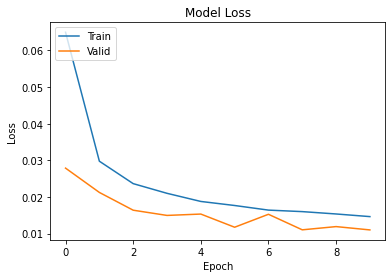

In [17]:
plt.plot(clf_1_history.history['loss'])
plt.plot(clf_1_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [18]:
# one-hot encodig label for softmax
num = np.unique(y_train_all, axis=0)
num = num.shape[0]

encoding_train = np.eye(num)[y_train_all]
encoding_valid = np.eye(num)[y_valid]

In [19]:
# Model
keras.backend.clear_session()

classifier_2 = keras.models.Sequential([
    keras.layers.Dense(22, activation='relu',input_shape=[29]),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

classifier_2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [20]:
clf_2_history = classifier_2.fit(denoising_x_train, encoding_train, epochs=10, validation_data=(denoising_x_valid,encoding_valid))

Epoch 1/10
11373/11373 [==============================] - 31s 3ms/step - loss: 0.0701 - accuracy: 0.9754 - val_loss: 0.0291 - val_accuracy: 0.9908
Epoch 2/10
11373/11373 [==============================] - 31s 3ms/step - loss: 0.0302 - accuracy: 0.9902 - val_loss: 0.0188 - val_accuracy: 0.9939
Epoch 3/10
11373/11373 [==============================] - 31s 3ms/step - loss: 0.0247 - accuracy: 0.9923 - val_loss: 0.0172 - val_accuracy: 0.9949
Epoch 4/10
11373/11373 [==============================] - 32s 3ms/step - loss: 0.0218 - accuracy: 0.9933 - val_loss: 0.0151 - val_accuracy: 0.9955
Epoch 5/10
11373/11373 [==============================] - 31s 3ms/step - loss: 0.0196 - accuracy: 0.9941 - val_loss: 0.0163 - val_accuracy: 0.9951
Epoch 6/10
11373/11373 [==============================] - 30s 3ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.0139 - val_accuracy: 0.9958
Epoch 7/10
11373/11373 [==============================] - 30s 3ms/step - loss: 0.0175 - accuracy: 0.9947 - val_loss: 0

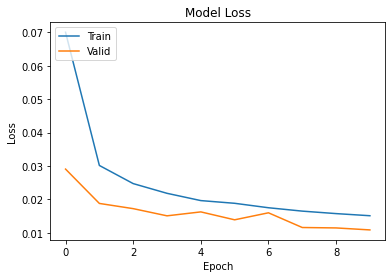

In [21]:
plt.plot(clf_2_history.history['loss'])
plt.plot(clf_2_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [22]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([56864,    98]))

In [23]:
denoising_x_test = denoising_ae.predict(x_test)

In [24]:
result = classifier_1.predict(denoising_x_test)
result = np.where(result > 0.5, 1, 0)

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, result)
average_precision = average_precision_score(y_test, result)

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.20')

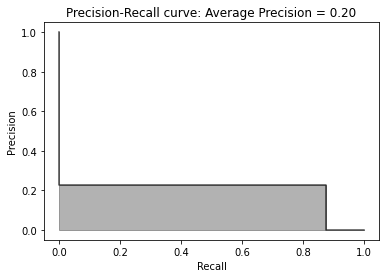

In [26]:
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall,precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, result)
areaUnderROC = auc(fpr,tpr)

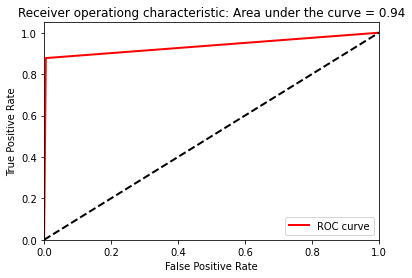

In [28]:
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0,1],[0,1],color='k', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operationg characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc='lower right')
plt.show()

In [29]:
result2 = classifier_2.predict(denoising_x_test)
result2 = result2.argmax(1)

In [30]:
precision, recall, thresholds = precision_recall_curve(y_test, result2)
average_precision = average_precision_score(y_test, result2)

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.24')

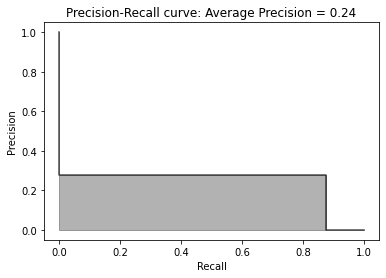

In [31]:
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall,precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, result2)
areaUnderROC = auc(fpr,tpr)

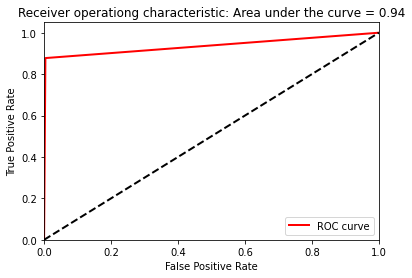

In [33]:
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0,1],[0,1],color='k', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operationg characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc='lower right')
plt.show()

In [34]:
base_result = base_classifier.predict(x_test)
base_result = np.where(base_result > 0.5, 1, 0)

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test, base_result)
average_precision = average_precision_score(y_test, base_result)

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.52')

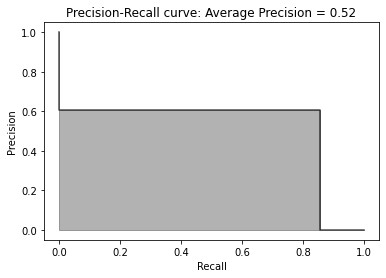

In [36]:
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall,precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, base_result)
areaUnderROC = auc(fpr,tpr)

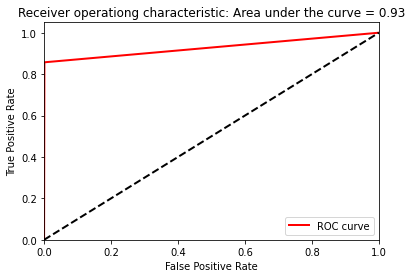

In [38]:
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0,1],[0,1],color='k', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operationg characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc='lower right')
plt.show()